In [1]:
!apt update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar -xvf spark-3.3.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.0-bin-hadoop3"
import findspark
findspark.init()

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:12 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal/main Sources [2,580 kB]
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,726 kB]
Get:1

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
%cd '/content/gdrive/My Drive/LDS9/'

/content/gdrive/My Drive/LDS9


In [4]:
import pyspark

In [5]:
from pyspark.sql import SparkSession

In [6]:
spark = SparkSession.builder.appName('cau4').getOrCreate()

In [283]:
# em xóa cột trong file excel để header với column ko bị mismatch nửa ạ
df = spark.read.csv("tmdb_5000_movies.csv",inferSchema=True, header=True, multiLine=True)

### Explore data

In [284]:
df.count()

4803

In [285]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)



In [286]:
df.show(5)

+------+--------------------+----------+--------------------+--------------------+
|    id|            overview|popularity|             tagline|               title|
+------+--------------------+----------+--------------------+--------------------+
| 19995|In the 22nd centu...|150.437577|Enter the World o...|              Avatar|
|   285|Captain Barbossa,...|139.082615|At the end of the...|Pirates of the Ca...|
|206647|A cryptic message...|107.376788|A Plan No One Esc...|             Spectre|
| 49026|Following the dea...| 112.31295|     The Legend Ends|The Dark Knight R...|
| 49529|John Carter is a ...| 43.926995|Lost in our world...|         John Carter|
+------+--------------------+----------+--------------------+--------------------+
only showing top 5 rows



### Tiền xử lý

In [287]:
# chọn các cột cần thiết
df = df.select(['title', 'tagline', 'overview'])

In [288]:
# check null, nan
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).toPandas().T

,0
title,0
tagline,0
overview,0


In [289]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas().T

,0
title,14
tagline,793
overview,3


In [290]:
# số lượng tagline bị null quá lớn nên xóa đi sẽ ảnh hưởng chất lượng data, 
# hơn nửa chữ ở các cột còn lại tương ứng vẫn có thể sử dụng đc nên fillna thành chuỗi rõng để concat
df = df.fillna(value="", subset=["title","tagline","overview"])

In [291]:
df.createOrReplaceTempView("temp")

In [292]:
data = spark.sql('''select CONCAT(title,' ',tagline,' ',overview) as text from temp''')

In [293]:
data.show(5)

+--------------------+
|                text|
+--------------------+
|Avatar Enter the ...|
|Pirates of the Ca...|
|Spectre A Plan No...|
|The Dark Knight R...|
|John Carter Lost ...|
+--------------------+
only showing top 5 rows



In [294]:
from pyspark.ml.feature import Tokenizer,StopWordsRemover, RegexTokenizer
from pyspark.ml.feature import CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector

In [295]:
# dùng regex vì có quá nhiều dấu câu dư thừa
regexTokenizer = RegexTokenizer(inputCol="text", outputCol="token_text",pattern ="\\W")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')

### Pipeline

In [296]:
from pyspark.ml import Pipeline

In [297]:
data_prep_pipe = Pipeline(stages=[regexTokenizer,stopremove])

In [298]:
cleaner = data_prep_pipe.fit(data)

In [299]:
clean_data = cleaner.transform(data)

### Model

In [300]:
from pyspark.ml.clustering import KMeans

In [302]:
clean_data = clean_data.select(['stop_tokens'])

In [303]:
clean_data.show(5, truncate = False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|stop_tokens                                                                                                                                                                                                                                                                                                                                                                                                                          |
+-------------------------------------------------------------------------------------------------------------------------------------------------------

In [304]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
data_prep_pipe = Pipeline(stages=[count_vec,idf,vec_assembler])
vec_assembler = VectorAssembler(inputCols = ['tf_idf'], outputCol='features_x')
data_prep_pipe = Pipeline(stages=[count_vec,idf,vec_assembler])
cleaner = data_prep_pipe.fit(clean_data)
encoded = cleaner.transform(clean_data)

In [305]:
# scale dữ liệu để knn tính toán lẹ hơn
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features_x",
 outputCol="features",
 withStd=True,
 withMean=False)
scalerModel = scaler.fit(encoded)
encoded = scalerModel.transform(encoded)

In [306]:
encoded.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------

In [307]:
# chọn số cluster
from pyspark.ml.evaluation import ClusteringEvaluator
k_list = []
silhouette_list = []
for k in range(2,11):
  kmeans = KMeans(featuresCol='features',k=k)
  model = kmeans.fit(encoded)
  results = model.transform(encoded)
  evaluator = ClusteringEvaluator(featuresCol='features')
  silhouette = evaluator.evaluate(results)
  k_list.append(k)
  silhouette_list.append(silhouette)
  print("With k =", k, "silhouette = " + str(silhouette))

With k = 2 silhouette = -0.24363599416065002
With k = 3 silhouette = 0.19393044332489753
With k = 4 silhouette = 0.41008995193482184
With k = 5 silhouette = 0.17280243505927378
With k = 6 silhouette = -0.2659848931557692
With k = 7 silhouette = -0.14735360151969634
With k = 8 silhouette = 0.16691282495187917
With k = 9 silhouette = -0.14610227756162206
With k = 10 silhouette = -0.2646664673315362


theo quan sát, ta thấy rằng chọn k tầm bằng 4 là vừa

In [308]:
kmeans = KMeans(featuresCol='features',k=4)
model = kmeans.fit(encoded)
results = model.transform(encoded)

In [309]:
results.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         stop_tokens|               c_vec|              tf_idf|          features_x|            features|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|[avatar, enter, w...|(22434,[3,41,88,2...|(22434,[3,41,88,2...|(22434,[3,41,88,2...|(22434,[3,41,88,2...|         0|
|[pirates, caribbe...|(22434,[0,3,14,62...|(22434,[0,3,14,62...|(22434,[0,3,14,62...|(22434,[0,3,14,62...|         0|
|[spectre, plan, o...|(22434,[1,14,56,8...|(22434,[1,14,56,8...|(22434,[1,14,56,8...|(22434,[1,14,56,8...|         0|
|[dark, knight, ri...|(22434,[2,16,29,5...|(22434,[2,16,29,5...|(22434,[2,16,29,5...|(22434,[2,16,29,5...|         0|
|[john, carter, lo...|(22434,[3,21,41,4...|(22434,[3,21,41,4...|(22434,[3,21,41,4...|(22434,[3,21,41,4...|         0|
|[spider, man, 3, ...|(22434,[2,4,5,63,...|(22434,[2,4,5

In [310]:
from wordcloud import WordCloud

In [311]:
from pyspark.sql.functions import explode_outer
results = results.select(results.prediction,explode_outer(clean_data.stop_tokens))

In [312]:
# tách ra 4 cluster dựa theo số đc model phân chia ở prediction
cluster_0 = results.select('col').where(results.prediction == 0)
cluster_1 = results.select('col').where(results.prediction == 1)
cluster_2 = results.select('col').where(results.prediction == 2)
cluster_3 = results.select('col').where(results.prediction == 3)

In [313]:
# i[0] nghĩa là lấy ra value của cell đó
text0 = " ".join(i[0] for i in cluster_0.collect())
text1 = " ".join(i[0] for i in cluster_1.collect())
text2 = " ".join(i[0] for i in cluster_2.collect())
text3 = " ".join(i[0] for i in cluster_3.collect())

In [314]:
wordcloud_0 = WordCloud(background_color='white', width=800, height=400).generate(text0)
wordcloud_1 = WordCloud(background_color='white', width=800, height=400).generate(text1)
wordcloud_2 = WordCloud(background_color='white', width=800, height=400).generate(text2)
wordcloud_3 = WordCloud(background_color='white', width=800, height=400).generate(text3)

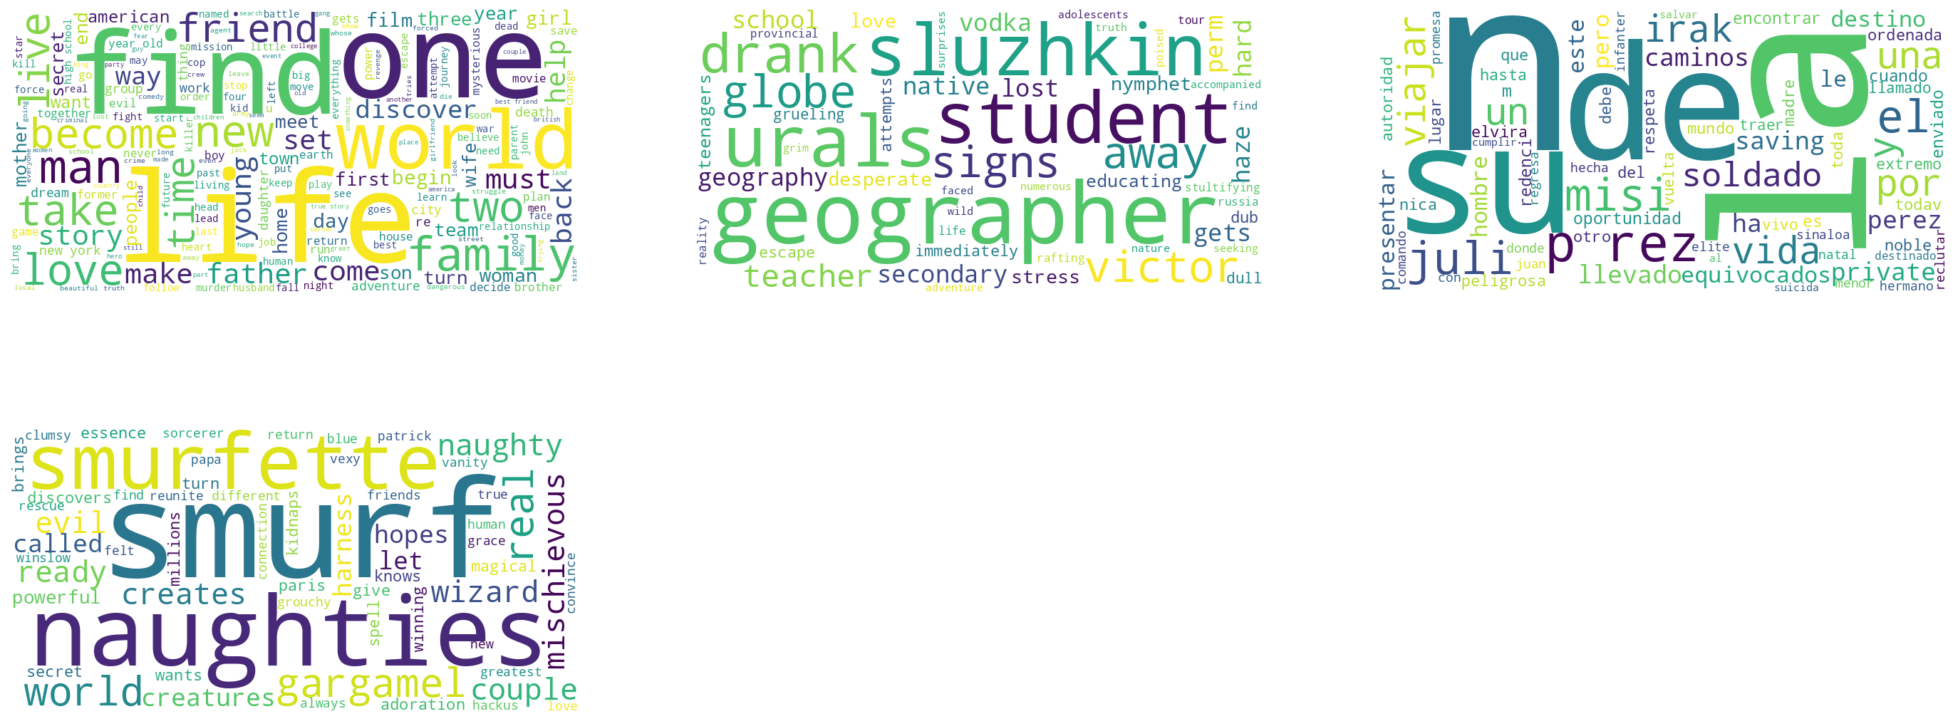

In [315]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25, 10))
plt.subplot(231)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis('off')
plt.subplot(232)
plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis('off')
plt.subplot(233)
plt.imshow(wordcloud_2, interpolation='bilinear')
plt.axis('off')
plt.subplot(234)
plt.imshow(wordcloud_3, interpolation='bilinear')
plt.axis('off')
plt.show()

* Nhận xét về 4 cụm:

1.   cụm 1: có vẻ như là chủ đề về gia đình và cuộc sống
2.   cụm 2: có vẻ như là chủ đề về khoa học và trường học
3.   cụm 3: cụm này tương đối khó hiểu, xuất hiện nhiều chữ không phải tiếng anh em không biết phân vào genre nào
4.   cụm 4: có vẻ như là chủ đề về comedy và fantasy world
